## **GloVe 임베딩을 활용하여 텍스트 분석하기**

훈련 데이터가 부족하여 작업에 맞는 임베딩 벡터를 계산할 수 없다면, 사전 훈련된 단어 임베딩을 사용할 수 있다.

여기서는 스탠포드 대학의 연구자들이 개발한 GloVe를 활용하여, 영화 리뷰 분석을 해보았다.

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Epoch 1/10
63/63 [==============================] - 1s 11ms/step - loss: 1.0350 - acc: 0.5501 - val_loss: 0.7470 - val_acc: 0.4848
Epoch 2/10
63/63 [==============================] - 1s 8ms/step - loss: 0.6404 - acc: 0.6560 - val_loss: 0.9414 - val_acc: 0.4920
Epoch 3/10
63/63 [==============================] - 1s 8ms/step - loss: 0.5459 - acc: 0.7234 - val_loss: 0.9889 - val_acc: 0.5504
Epoch 4/10
63/63 [==============================] - 1s 8ms/step - loss: 0.5439 - acc: 0.7981 - val_loss: 0.6301 - val_acc: 0.6612
Epoch 5/10
63/63 [==============================] - 1s 9ms/step - loss: 0.3546 - acc: 0.8740 - val_loss: 0.9393 - val_acc: 0.5746
Epoch 6/10
63/63 [==============================] - 1s 9ms/step - loss: 0.2556 - acc: 0.9049 - val_loss: 0.7382 - val_acc: 0.6434
Epoch 7/10
63/63 [==============================] - 1s 9ms/step - loss: 0.2045 - acc: 0.93

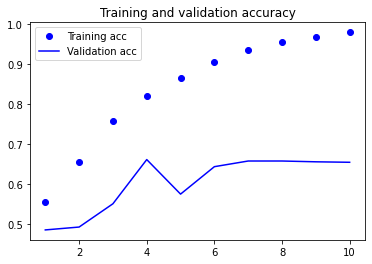

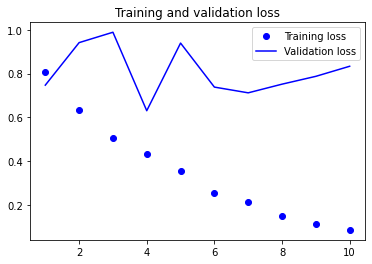

In [18]:
import os
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf

from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Activation, Flatten, Embedding
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from google.colab import drive
drive.mount('/content/drive')


train_dir = '/content/drive/MyDrive/aclImdb.zip (Unzipped Files)/aclImdb/test'

labels = []
texts = []

# 훈련용 리뷰 하나를 문자열 하나로 만들고, neg/pos 라벨링도 한다.
for label_type in ['neg', 'pos']:
  dir_name = os.path.join(train_dir, label_type)
  for fname in os.listdir(dir_name):
    if fname[-4:] == '.txt':
      f = open(os.path.join(dir_name, fname), encoding="utf8")
      texts.append(f.read())
      f.close()
      if label_type == 'neg':
        labels.append(0)
      else:
        labels.append(1)

labels = np.array(labels)

maxlen = 100
training_samples = 2000
validation_samples = 5000
max_words = 10000

# 문자열을 숫자로 인덱싱한다. 
tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(texts)
sequences = tokenizer.texts_to_sequences(texts)
data = pad_sequences(sequences, maxlen=maxlen)

word_index = tokenizer.word_index

# 훈련용 데이터와 검증 데이터를 나눈다.
indices = np.arange(data.shape[0])
np.random.shuffle(indices)
data = data[indices]
labels = labels[indices]

x_train = data[:training_samples]
y_train = labels[:training_samples]
x_val = data[training_samples: training_samples + validation_samples]
y_val = labels[training_samples: training_samples + validation_samples]

# Glove 단어 임베딩 내려받기
glove_dir = '/content/drive/MyDrive/glove.6B.zip (Unzipped Files)'

embeddings_index = {}
f = open(os.path.join(glove_dir, 'glove.6B.100d.txt'), encoding="utf8")
for line in f:
  values = line.split()
  word = values[0]
  coefs = np.array(values[1:], dtype = 'float32')
  embeddings_index[word] = coefs
f.close()

# Embedding층에 주입할 수 있도록 임베딩 행렬을 만든다.
embedding_dim = 100

embedding_matrix = np.zeros((max_words, embedding_dim))
for word, i in word_index.items():
  if i < max_words:
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
      embedding_matrix[i] = embedding_vector

input = Input(shape = (maxlen,))
R = Embedding(max_words, embedding_dim)(input)
R = Flatten()(R)
R = Dense(32)(R)
R = Activation('relu')(R)
R = Dense(1)(R)
R = Activation('sigmoid')(R)

model = Model(inputs = [input], outputs = R)

# model의 첫 번째 가중치 층을 embedding_matrix로 교체한다.
model.layers[1].set_weights([embedding_matrix])
model.layers[1].trainable = False  # 동결한다.

model.compile(optimizer='rmsprop', 
              loss='binary_crossentropy', 
              metrics=['acc'])
history = model.fit(x_train, y_train,
                    epochs=10,
                    batch_size=32,
                    validation_data=(x_val, y_val))

model.save_weights('pre_trained_glove_model.h5')

# 결과값 그리기
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label = 'Training acc')
plt.plot(epochs, val_acc, 'b', label = 'Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label = 'Training loss')
plt.plot(epochs, val_loss, 'b', label = 'Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

